Epoch 1, Loss: 6.3857
Epoch 2, Loss: 4.2629
Epoch 3, Loss: 2.8684
Epoch 4, Loss: 1.8551
===Epoch: 4 Step: 0===
--- (- g) is towards decreasing 100-th batch loss
--- (- m) is towards decreasing 100-th batch loss
--- 100-th batch loss decreased by -0.0057!
===Epoch: 4 Step: 1===
--- (- g) is towards decreasing 100-th batch loss
--- (- m) is towards decreasing 100-th batch loss
--- 100-th batch loss decreased by -0.0052!
===Epoch: 4 Step: 2===
--- (- g) is towards decreasing 100-th batch loss
--- (- m) is towards decreasing 100-th batch loss
--- 100-th batch loss decreased by -0.0048!
===Epoch: 4 Step: 3===
--- (- g) is towards decreasing 100-th batch loss
--- (- m) is towards decreasing 100-th batch loss
--- 100-th batch loss decreased by -0.0044!
===Epoch: 4 Step: 4===
--- (- m) is towards decreasing 100-th batch loss
--- 100-th batch loss decreased by -0.0039!
===Epoch: 4 Step: 5===
--- (- g) is towards decreasing 100-th batch loss
--- (- m) is towards decreasing 100-th batch loss
--- 

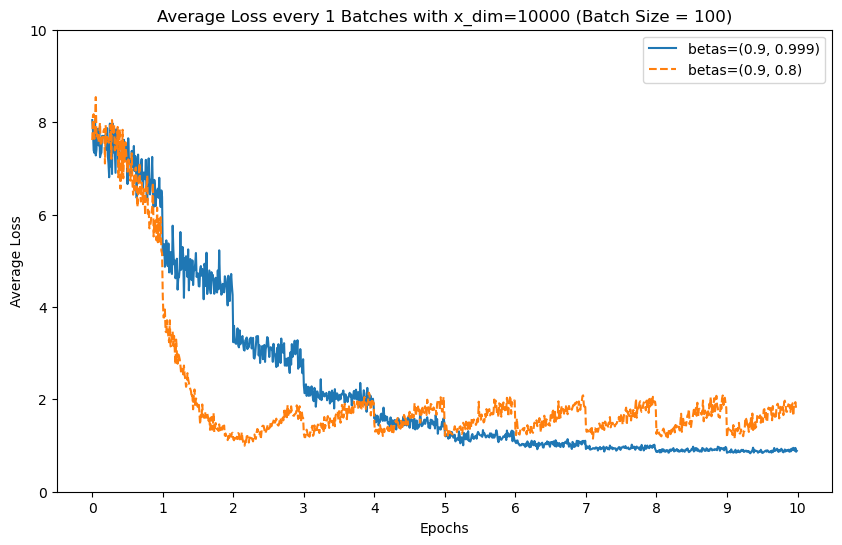

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

epoch_global = 0  # global variable to keep track of the current epoch
beta2_global = 0  # global variable to keep track of the current beta2
i_global = 0  # global variable to keep track of the current iteration

# record variables for epoch EPOCH_PLOT when beta2 is BETA2_PLOT for inspection and plot purpose
# say, for analysis, we can plot the loss curve for epoch EPOCH_PLOT and beta2 BETA2_PLOT
# for example, EPOCH_PLOT = 4, BETA2_PLOT = 0.8
EPOCH_PLOT = 4
BETA2_PLOT = 0.999

class SimpleRMSprop:
    '''A simple implementation of RMSprop optimizer'''
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        self.lr = lr  # learning rate
        self.beta = beta  # momentum parameters
        self.epsilon = epsilon  # small value to avoid division by zero
        self.v = 0  # Accumulated gradient squared

    def update(self, grad):
        # Update the accumulated squared gradient
        self.v = self.beta * self.v + (1 - self.beta) * (grad ** 2)
        # Compute the RMSprop update
        return -self.lr * grad / (np.sqrt(self.v) + self.epsilon)
    
class SimpleAdam:
    '''A simple implementation of Adam optimizer'''
    def __init__(self, lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta_1 = beta_1  # Exponential decay rate for the first moment estimates
        self.beta_2 = beta_2  # Exponential decay rate for the second moment estimates
        self.epsilon = epsilon
        self.m = 0  # First moment
        self.v = 0  # Second moment
        self.t = 0  # Time step
        
    def update(self, grad):
        # Update the first and second moments
        # return delta_x, namely (x - x_prev)
        self.t += 1  # Increment the time step
        v_prev = deepcopy(self.v)
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * grad  # Update the first moment
        # record m for one epoch for inspection and plot purpose
        if beta2_global == BETA2_PLOT and (epoch_global == EPOCH_PLOT): 
            m_all[:, i_global // 100] = deepcopy(self.m)
            m_norm_history.append(np.linalg.norm(self.m))
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (grad ** 2)  # Update the second moment
        m_hat = self.m / (1 - self.beta_1 ** self.t)  # Bias correction for the first moment
        v_hat = self.v / (1 - self.beta_2 ** self.t)  # Bias correction for the second moment
        # record v for one epoch for inspection and plot purpose
        if beta2_global == BETA2_PLOT and (epoch_global == EPOCH_PLOT):
            v_all[:, i_global // 100] = deepcopy(self.v)
            v_norm_history.append(np.linalg.norm(self.v))
        delta_x = -self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return delta_x

def quadratic_function(x, coeffs, x_dim_idx):
    '''Define a quadratic function acting on one dimension of x'''
    # coeffs = [a, b, c]
    # return a * (x[x_dim_idx] - c)**2 + b
    return coeffs[0] * (x[x_dim_idx] - coeffs[2])**2 + coeffs[1]
 
def gradient_quadratic(x, coeffs, x_dim_idx):
    '''Gradient of the quadratic function'''
    grad = np.zeros_like(x)
    grad[x_dim_idx] = 2 * coeffs[0] * (x[x_dim_idx] - coeffs[2])
    return grad

# for one epoch for inspection and plot purpose
grad_norm_history = []  # record grad norm for an epoch
m_norm_history = []  # record m norm for an epoch
v_norm_history = []  # record v norm for an epoch
v_all = np.zeros((10000, 100))  # record v for an epoch
m_all = np.zeros((10000, 100))  # record m for an epoch
loss_all = []  # record initial loss of all batchs at the start of epoch EPOCH_PLOT
grad_all = np.zeros((10000, 100))  # record grad for an epoch
grad_batch_100 = np.zeros((10000, 100))  # record grad of 100-th batch for an epoch
loss_batch_100 = np.zeros((100))  # record loss of 100-th batch for an epoch
loss_batch_100_post = np.zeros((100))  # record loss of 100-th batch after each x update for an epoch
delta_x_all = np.zeros((10000, 100))  # record delta_x for an epoch

# Simulate training
# incrementally solving high dimensional convex quadratic programming
def simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.01, betas=(0.9, 0.999), plot_every=10, shuffle=True):
    beta_1 = betas[0]
    beta_2 = betas[1]
    x = 3 * np.ones(x_dim) # Initialize x for all dimensions
    optimizer = SimpleAdam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    
    # Define quadratic functions
    # each function acts on one dim of x
    # each function if quadratic, convex, with three parameters [a, b, c]
    coeffs_list = np.random.uniform(0.5, 1.0, size=(num_functions, 3))  # Coefficients for random functions
    coeffs_list[:, 2] = np.random.uniform(-1, 1, size=num_functions)  # Minima near zero
    
    # Assign each function to act on a random dimension of x
    x_dim_indices = np.random.randint(0, x_dim, size=num_functions)
    
    avg_loss_history = []  # record the average loss over all epochs
    # each point is added after plot_every epochs
    for epoch in range(num_epochs):
        global epoch_global
        epoch_global = epoch
        global beta2_global
        beta2_global = betas[1]
        
        # Shuffle the coefficients and indices if shuffle=True
        if shuffle:
            perm = np.random.permutation(num_functions)
            coeffs_list = coeffs_list[perm]
            x_dim_indices = x_dim_indices[perm]
        
        # compute loss init for all batchs
        if beta2_global  == BETA2_PLOT and (epoch_global == EPOCH_PLOT):
            for i in range(0, num_functions, batch_size):
                batch_coeffs = coeffs_list[i:i+batch_size]
                batch_dim_indices = x_dim_indices[i:i+batch_size]
                
                batch_loss = 0
                batch_grad = np.zeros_like(x)
                for coeffs, x_dim_idx in zip(batch_coeffs, batch_dim_indices):
                    batch_loss += quadratic_function(x, coeffs, x_dim_idx)
                    batch_grad += gradient_quadratic(x, coeffs, x_dim_idx)
                
                # Average loss and gradient across the batch
                batch_loss /= batch_size
                batch_grad /= batch_size
                loss_all.append(batch_loss)
        
        # iterate over batchs     
        accumulated_loss = 0  # accumulate loss over plot_every batchs
        for i in range(0, num_functions, batch_size):
            global i_global
            i_global = i
            # batch of quadratic functions
            batch_coeffs = coeffs_list[i:i+batch_size]
            batch_dim_indices = x_dim_indices[i:i+batch_size]
            
            # Compute loss for the current batch
            batch_loss = 0
            batch_grad = np.zeros_like(x)
            for coeffs, x_dim_idx in zip(batch_coeffs, batch_dim_indices):
                batch_loss += quadratic_function(x, coeffs, x_dim_idx)
                batch_grad += gradient_quadratic(x, coeffs, x_dim_idx)
            
            # Average loss and gradient across the batch
            batch_loss /= batch_size
            batch_grad /= batch_size
            
            if beta2_global == BETA2_PLOT and (epoch_global == EPOCH_PLOT):
                # record the current grad
                grad_all[:, i_global // 100] = deepcopy(batch_grad)
                
                # compute the gradient of 100-th batch's loss at current step
                i_100 = 9900
                batch_loss_100 = 0
                batch_coeffs_100 = coeffs_list[i_100:i_100+batch_size]
                batch_dim_indices_100 = x_dim_indices[i_100:i_100+batch_size]
                batch_grad_100 = np.zeros_like(x)
                for coeffs, x_dim_idx in zip(batch_coeffs_100, batch_dim_indices_100):
                    batch_loss_100 += quadratic_function(x, coeffs, x_dim_idx)
                    batch_grad_100 += gradient_quadratic(x, coeffs, x_dim_idx)
                batch_loss_100 /= batch_size
                batch_grad_100 /= batch_size
                grad_batch_100[:, i_global // 100] = deepcopy(batch_grad_100)
                loss_batch_100[i_global // 100] = batch_loss_100
                #print(f'>>> 100-th batch loss at step {i // 100} of epoch {epoch} before x update: {batch_loss_100:.4f}', batch_loss_100)
                
            # accumulate loss over plot_every batchs
            accumulated_loss += batch_loss
            
            # Update x using the optimizer based on batch gradient
            delta_x = optimizer.update(batch_grad)
            
            # monitor special case: np.dot(batch_grad_100, delta_x)
            if beta2_global == BETA2_PLOT and epoch == EPOCH_PLOT:
                # record grad_norm
                grad_norm_history.append(np.linalg.norm(batch_grad))
                
                #record delta_x
                delta_x_all[:, i_global // 100] = deepcopy(delta_x)
                
                # compute the loss of batch 100 after updating x
                i_100 = 9900
                batch_loss_100_post = 0
                batch_coeffs_100 = coeffs_list[i_100:i_100+batch_size]
                batch_dim_indices_100 = x_dim_indices[i_100:i_100+batch_size]
                batch_grad_100_post = np.zeros_like(x)
                for coeffs, x_dim_idx in zip(batch_coeffs_100, batch_dim_indices_100):
                    batch_loss_100_post += quadratic_function(x + delta_x, coeffs, x_dim_idx)
                    batch_grad_100_post += gradient_quadratic(x + delta_x, coeffs, x_dim_idx)
                batch_loss_100_post /= batch_size
                batch_grad_100_post /= batch_size
                loss_batch_100_post[i_global // 100] = batch_loss_100_post
                #print(f'>>> 100-th batch loss at step {i // 100} of epoch {epoch} after x update: {batch_loss_100_post:.4f}', batch_loss_100_post)
                print(f"===Epoch: {epoch} Step: {i // 100}===")
                if np.dot(batch_grad_100, batch_grad) > 0:
                    print(f'--- (- g) is towards decreasing 100-th batch loss')
                    
                if np.dot(batch_grad_100, m_all[:, i // 100]) > 0:
                    print(f'--- (- m) is towards decreasing 100-th batch loss')
                    
                if batch_loss_100_post > batch_loss_100:    
                    print(f'+++ 100-th batch loss increased by {batch_loss_100_post - batch_loss_100:.4f}!')
                    
                if batch_loss_100_post < batch_loss_100:
                    print(f'--- 100-th batch loss decreased by {batch_loss_100_post - batch_loss_100:.4f}!')
                    
                          
            # update x
            x += delta_x
            
            # After every 'plot_every' batches, record the average loss and reset accumulated loss
            if (i // batch_size + 1) % plot_every == 0:
                avg_loss_history.append(accumulated_loss / plot_every)
                accumulated_loss = 0
        
        # Record the loss at the end of each epoch
        print(f'Epoch {epoch+1}, Loss: {avg_loss_history[-1]:.4f}')
    
    return avg_loss_history

# Set the parameters for the simulation
num_epochs = 10
batch_size = 100
num_functions = 10000  # Total number of quadratic functions
x_dim = 10000  # Dimensionality of input vector x
plot_every = 1  # Plot average loss every plot_every batches
# Simulate training with two different beta values
betas_1 = (0.9, 0.999)
betas_2 = (0.9, 0.8)
loss_history_betas_1 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, betas=betas_1, plot_every=plot_every, shuffle=True)
loss_history_betas_2 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, betas =betas_2, plot_every=plot_every, shuffle=True)

# Plot the average loss history every 'plot_every' batches
t = np.arange(len(loss_history_betas_1))
t = t / (num_functions / batch_size / plot_every)
t_ticks = np.arange(0, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(t, loss_history_betas_1, label=f'betas=({betas_1[0]}, {betas_1[1]})', linestyle='-')
plt.plot(t, loss_history_betas_2, label=f'betas=({betas_2[0]}, {betas_2[1]})', linestyle='--')
plt.gca().set_xticks(t_ticks)
plt.ylim([0, 10])
plt.xlabel(f'Epochs')
plt.ylabel('Average Loss')
plt.title(f'Average Loss every {plot_every} Batches with x_dim={x_dim} (Batch Size = {batch_size})')
plt.legend()
plt.show()

## loss of all batches at the start of epoch 4

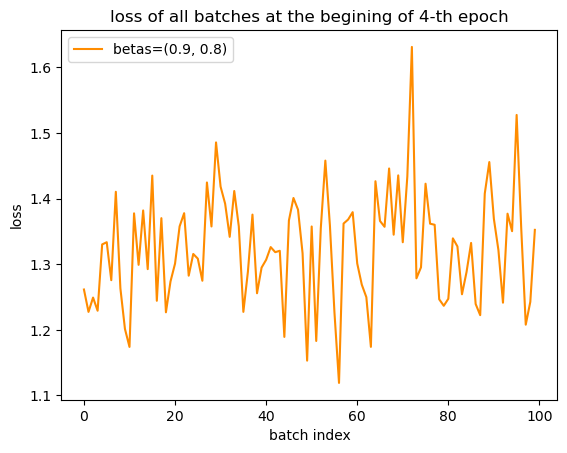

In [4]:
import matplotlib.pyplot as plt
plt.plot(loss_all[:100], color='darkorange', label=f'betas=({betas_2[0]}, {betas_2[1]})')
plt.xlabel('batch index')
plt.ylabel('loss')
#plt.ylim(0, 10)
plt.title('loss of all batches at the begining of 4-th epoch')
plt.legend()

## $\|g_t\|$ over epoch 4

Text(0.5, 1.0, 'g norm over epoch 4')

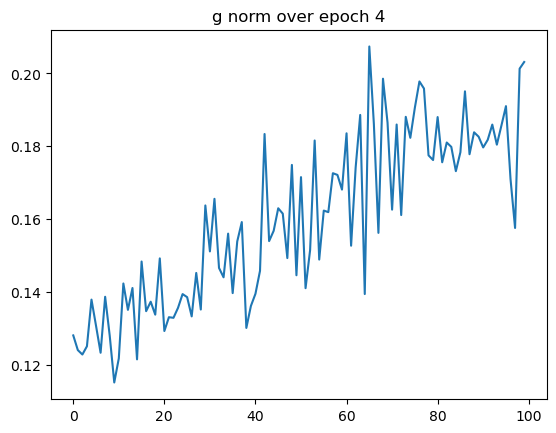

In [5]:
plt.plot(grad_norm_history)
plt.title('g norm over epoch 4')


## $\|m_t\|$ over epoch 4

Text(0.5, 1.0, 'm norm over epoch 4')

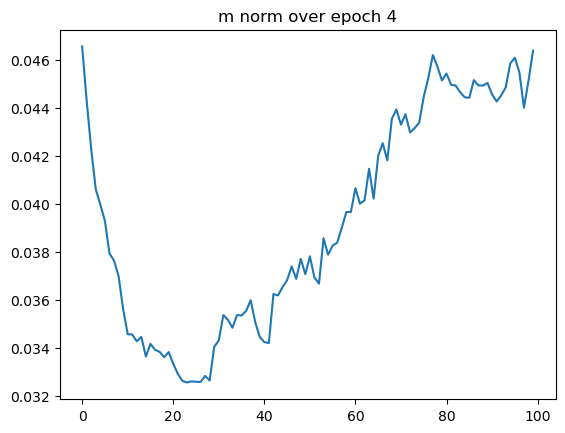

In [6]:
plt.plot(m_norm_history)
y_low = .032
#plt.ylim([y_low, 3 * y_low])
plt.title('m norm over epoch 4')

## $\|\upsilon_t\|$ over epoch 4

[]

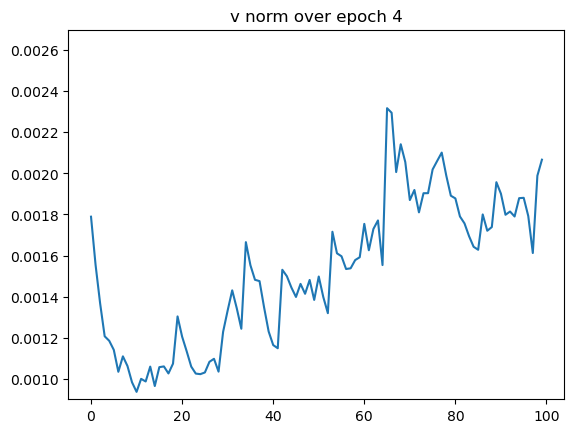

In [7]:
plt.plot(v_norm_history)
y_low = .0009
plt.ylim(y_low, 3 * y_low)
plt.title('v norm over epoch 4')
plt.plot()

## m's components visualization

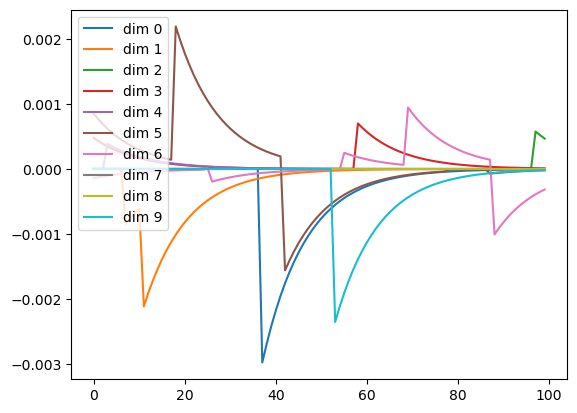

In [8]:
for j in range(10, 20):
    plt.plot(m_all[j], label=f'dim {j - 10}')
plt.legend(loc='upper left')

## v's components visualization

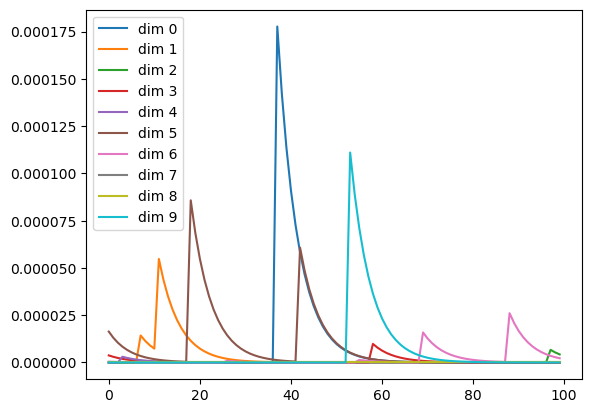

In [9]:
for j in range(10, 20):
    plt.plot(v_all[j], label=f'dim {j - 10}')
plt.legend(loc='upper left')

## $\langle g_t, \nabla l^b_t \rangle$ curve over epoch 4
epoch = 4, beta1 = 0.9, beta2 = BETA2_PLOT

b = 100


### t in range [0, 100]

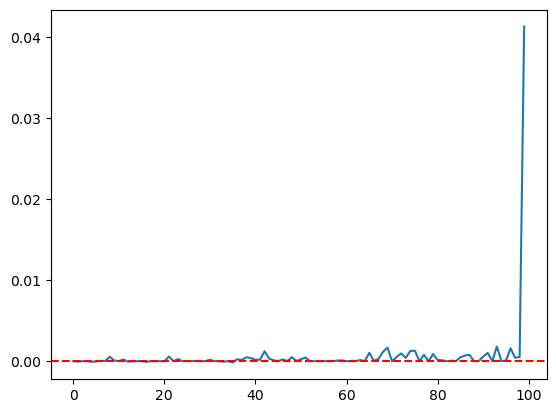

In [10]:
g_dot_g = []
for i in range(100):
    g_dot_g.append(np.dot(grad_all[:, i], grad_batch_100[:, i]))
plt.plot(g_dot_g)
plt.axhline(y=0, color='red', linestyle='--')

### t in range [0, 99]

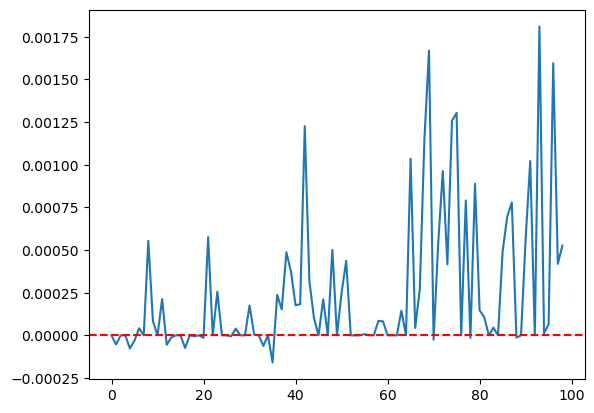

In [11]:
g_dot_g = []
for i in range(99):
    g_dot_g.append(np.dot(grad_all[:, i], grad_batch_100[:, i]))
plt.plot(g_dot_g)
plt.axhline(y=0, color='red', linestyle='--')

## $\langle m_t, \nabla l^b_t \rangle$ curve over epoch 4
epoch = 4, beta1 = 0.9, beta2 = BETA2_PLOT

b = 100


### t in range [0, 100]

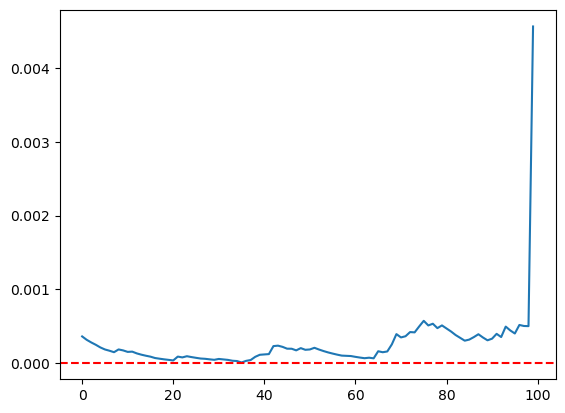

In [12]:
m_dot_g = []
for i in range(100):
    m_dot_g.append(np.dot(m_all[:, i], grad_batch_100[:, i]))
plt.plot(m_dot_g)
plt.axhline(y=0, color='red', linestyle='--')

### t in range [0, 99]

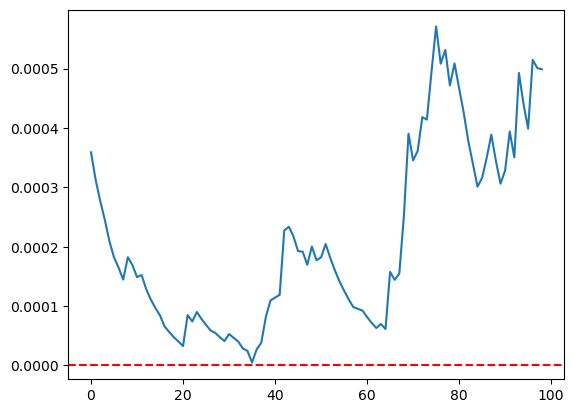

In [13]:
m_dot_g = []
for i in range(99):
    m_dot_g.append(np.dot(m_all[:, i], grad_batch_100[:, i]))
plt.plot(m_dot_g)
plt.axhline(y=0, color='red', linestyle='--')

## $\langle \Delta x_t, \nabla l^b_t \rangle$ curve over epoch 4
epoch = 4, beta1 = 0.9, beta2 = BETA2_PLOT

b = 100


### t in range [0, 100]

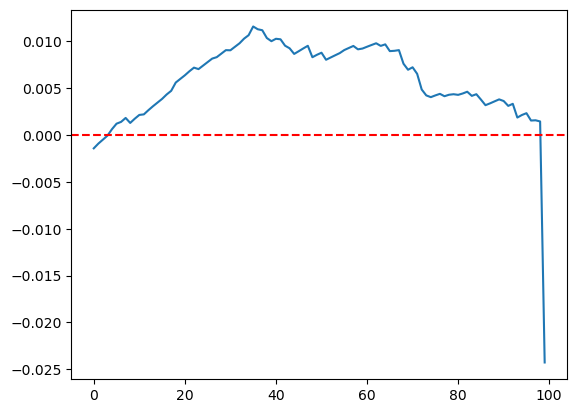

In [14]:
delta_x_dot_g = []
for i in range(100):
    delta_x_dot_g.append(np.dot(delta_x_all[:, i], grad_batch_100[:, i]))
plt.plot(delta_x_dot_g)
plt.axhline(y=0, color='red', linestyle='--')

## Accumulated sum of $\langle \Delta x_t, \nabla l^b_t \rangle$ over epoch 4

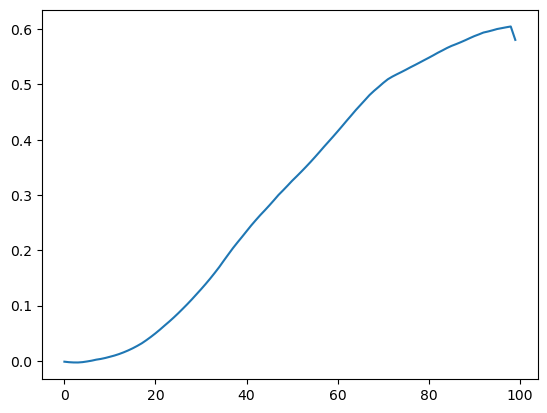

In [15]:
accumulated_sum = np.cumsum(delta_x_dot_g)
plt.plot(accumulated_sum)

## $l^b$ curve over epoch 4
b = 100

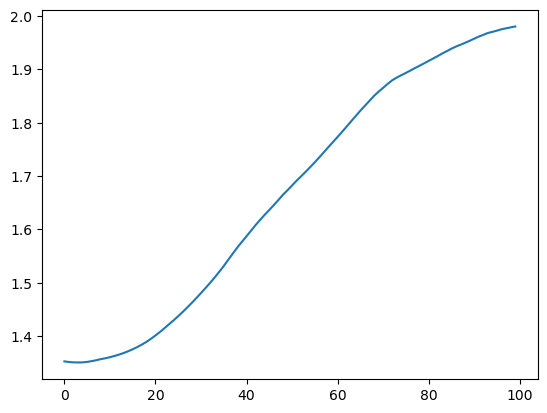

In [16]:
plt.plot(loss_batch_100)

[]

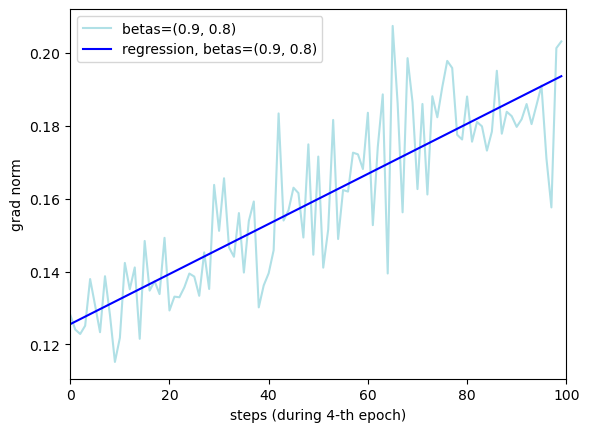

In [17]:
y1 = grad_norm_history[:100]
#y2 = grad_norm_history[100:]
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
x = np.arange(100)
t = [i / 100 for i in x]
# Fit with polyfit
b1, m1 = polyfit(x, y1, 1)
#b2, m2 = polyfit(x, y2, 1)
plt.plot(x, y1, label=f'betas=({0.9}, {BETA2_PLOT})', color='powderblue')
#plt.plot(x, y2, label=f'betas=({betas_2[0]}, {betas_2[1]})', color='palegreen')
plt.plot(x, b1 + m1 * x, label=f'regression, betas=({betas_1[0]}, {BETA2_PLOT})', color='b')
#plt.plot(x, b2 + m2 * x, label=f'regression, betas=({betas_2[0]}, {betas_2[1]})', color='g')
plt.xlim(0, 100)
#plt.ylim(0.08, 0.22)
plt.xlabel('steps (during 4-th epoch)')
plt.ylabel('grad norm')
plt.legend()
plt.plot()